In [1]:
import os

import av
import cv2
import numpy as np
import pandas as pd
from torchvision import models
from torchvision.transforms import ToTensor, transforms

from tqdm.notebook import tqdm
from tqdm import trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


/data/vdimitrov/project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import cv2
import numpy as np
import albumentations as A


def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return frames



def write_video(name, video, frame_sample_rate):
    video_writer = cv2.VideoWriter(
        name,
        cv2.VideoWriter_fourcc(*'MJPG'),
        int(25 / frame_sample_rate),
        (video.shape[2], video.shape[1])
    )
    for frame in video:
        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video_writer.release()


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    while converted_len >= seg_len and clip_len > 1:
        clip_len -= 1
        converted_len = int(clip_len * frame_sample_rate)
    end_idx = converted_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


def apply_video_augmentations(video, transform):
    targets = {'image': video[0]}
    for i in range(1, video.shape[0]):
        targets[f'image{i}'] = video[i]
    transformed = transform(*video)
    transformed = np.concatenate(
        [np.expand_dims(transformed['image'], axis=0)]
        + [np.expand_dims(transformed[f'image{i}'], axis=0) for i in range(1, video.shape[0])]
    )
    return transformed


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pretrained transformer model

In [5]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(512, 15)
model.to(device)

/data/vdimitrov/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/vdimitrov/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Dataset preparation

In [6]:
df = pd.read_csv("dancing.csv")
df["video_path"] = "clips_2/" + df["youtube_id"] + ".mp4"

,Unnamed: 0,label,youtube_id,time_start,time_end,split,video_path
0,23948,belly dancing,uhX8rmHFLaY,116,126,train,clips_2/uhX8rmHFLaY.mp4
1,23843,belly dancing,-q0Wpf0WThk,317,327,train,clips_2/-q0Wpf0WThk.mp4
2,24142,belly dancing,P9mOEmlCEXY,62,72,train,clips_2/P9mOEmlCEXY.mp4
3,23467,belly dancing,mm5S2ftbb-k,32,42,train,clips_2/mm5S2ftbb-k.mp4
4,23982,belly dancing,TCbfIBb87hQ,134,144,train,clips_2/TCbfIBb87hQ.mp4


In [7]:
print("Before:", df.shape[0])
for i, row in df.iterrows():
    if not os.path.exists(row['video_path']):
        print(row['video_path'])
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
print("After:", df.shape[0])

Before: 3000
clips_2/PL3ex5IAQNw.mp4
clips_2/NJAIp24I9oQ.mp4
clips_2/_ubj_hjLdVc.mp4
clips_2/iQuTmRkOuIo.mp4
clips_2/Y_rtxFTnyWI.mp4
clips_2/cNvTm72aGcM.mp4
clips_2/YUJVnjzPZxI.mp4
clips_2/ooN3OOKuAjY.mp4
clips_2/sbvNyPubcFM.mp4
clips_2/g3E8Cjog6-k.mp4
clips_2/iJ5KAamDDP8.mp4
clips_2/kuJO1VapxuQ.mp4
clips_2/G0MfJoTOAOw.mp4
clips_2/yEEDk2CMOTI.mp4
clips_2/zt7XHcgHdEc.mp4
clips_2/Sw4Ggaya3ys.mp4
clips_2/xeemkepaczg.mp4
clips_2/s5GJdHQL_Wc.mp4
clips_2/N4UtAez9QVE.mp4
clips_2/0sCg3fIcMCA.mp4
clips_2/NLhhoE7es8g.mp4
clips_2/uvoBn-8AxHI.mp4
clips_2/F60UViJTih0.mp4
clips_2/xvNiI_ScL1I.mp4
clips_2/5JWfwsP06rQ.mp4
clips_2/eU7aTQHNTdw.mp4
clips_2/yJlFSAsm55A.mp4
clips_2/ros4Qypsgx8.mp4
clips_2/WfReigRwWL8.mp4
clips_2/Os66zjMaxyM.mp4
clips_2/tkU_8wbm5PI.mp4
clips_2/RB2LsZrsp7M.mp4
clips_2/900sTBL7rUI.mp4
clips_2/Fd8A6KMum_U.mp4
clips_2/eBswIBFiyBs.mp4
clips_2/gE3P4lxAgt4.mp4
clips_2/gFHv0ahXTGQ.mp4
clips_2/XtRSuv2pD5A.mp4
clips_2/KmeM_SSphxA.mp4
clips_2/9AkuTMwhHQE.mp4
clips_2/0f1vKMit9uw.mp4
cli

In [8]:
X_train, X_val, _, _ = train_test_split(df, df['label'])
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

In [9]:
labels = X_train["label"].unique()
labels2id = {label: i for i, label in enumerate(labels)}

In [10]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

to_tensor = ToTensor()

In [11]:
class ActionDataset(Dataset):

    def __init__(self, meta, transform=None):
        self.meta = meta
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            try:
                file_path = self.meta['video_path'].iloc[idx]
                container = av.open(file_path)

                indices = sample_frame_indices(clip_len=8, frame_sample_rate=5,
                                               seg_len=container.streams.video[0].frames)
                video = read_video_pyav(container, indices)
                # while video.shape[0] < 8:
                #     video = np.vstack([video, video[-1:]])

            except Exception as e:
                print("loop Error: ", e)
                continue
            break

        if self.transform:
            transformed = apply_video_augmentations(video, self.transform)
            video = transformed

        return video, self.meta['label'].iloc[idx]

    def validate_videos(self):
        for i, row in self.meta.iterrows():
            if not os.path.exists(row['video_path']):
                print(row['video_path'])
                self.meta.drop(i, inplace=True)
                continue

            self.__getitem__(i)
        self.meta.reset_index(drop=True, inplace=True)
        return self.meta

In [12]:
class VideoDataset(Dataset):
    def __init__(self, meta, max_length=128, transform=None):
        self.meta = meta
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        video = self.load_video(row['video_path'])
        # video = apply_video_augmentations(video, self.transform)
        for i in range(len(video)):
            video[i] = self.transform(video[i])
        video = torch.stack(video)
        labels_tensor = labels2id[self.meta['label'].iloc[idx]]
        labels_tensor = torch.tensor([labels_tensor]* len(video))
        return video, labels_tensor

    def load_video(self, path):
        container = av.open(path)
        indices = sample_frame_indices(clip_len=8, frame_sample_rate=5,
                                       seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, indices)
        frames = []
        for frame in video:
            frame = frame.to_image()
            # frame = cv2.resize(frame.to_ndarray(format="rgb24"), (224, 224))
            frames.append(frame)
        return frames

# Training

In [13]:
# clear gpu memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [14]:
train_dataset = VideoDataset(meta=X_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10, drop_last=True)

In [15]:
val_dataset = VideoDataset(meta=X_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=10, drop_last=False)

In [16]:
epochs = 30
lr = 1e-3

optimizer = optim.SGD(model.parameters(), lr)  # 289
loss_fun = nn.CrossEntropyLoss()

In [17]:
import copy

loss_history = {'train': [], 'val': [], 'test': []}
acc_history = {'train': [], 'val': [], 'test': []}
best_weights, bests_acc = copy.deepcopy(model.state_dict()), 0.0

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/resnet18")

In [19]:
!nvidia-smi

Mon May  6 22:03:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A2           On   | 00000000:03:00.0 Off |                    0 |
|  0%   45C    P0    20W /  60W |   2030MiB / 15356MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import torch
epochs = 30
all_preds = []
all_labels = []

for epoch in trange(epochs, desc='Epochs'):
    model.train()
    train_loss = []
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        grouped_inputs, grouped_labels = batch
        inputs = grouped_inputs.flatten(0, 1)
        Y = grouped_labels.flatten()

        inputs = inputs.to(device, dtype=torch.float32)
        Y = Y.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(inputs).to(device)
        preds = outputs.to(device)

        loss = loss_fun(preds, Y.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(preds) == Y.data)

        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(Y.cpu().detach().numpy())

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        loss_history["train"].append(epoch_loss)
        acc_history["train"].append(epoch_acc)

        train_loss.append(loss.item())
        writer.add_scalar(
                "Train loss per step", loss.item(), epoch * len(train_dataloader) + i
            )

    writer.add_scalar(
                "Mean train loss per epoch", np.mean(train_loss), epoch
            )

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]mmco: unref short failure


Batch 0:  2.854477643966675
Batch 1:  2.7865326404571533


mmco: unref short failure


Batch 2:  2.873196601867676
Batch 3:  2.952505588531494
Batch 4:  2.986220121383667
Batch 5:  2.8059136867523193
Batch 6:  2.8213179111480713
Batch 7:  2.797590970993042
Batch 8:  2.941171407699585
Batch 9:  2.7819504737854004
Batch 10:  2.8504092693328857
Batch 11:  2.8171184062957764
Batch 12:  2.870455026626587
Batch 13:  2.9118762016296387
Batch 14:  2.77229380607605
Batch 15:  2.856036424636841
Batch 16:  2.7759132385253906
Batch 17:  2.8823866844177246
Batch 18:  2.8264589309692383
Batch 19:  2.805522918701172
Batch 20:  2.7052555084228516
Batch 21:  2.8774101734161377
Batch 22:  2.8342463970184326
Batch 23:  2.9240918159484863


Epochs:   3%|▎         | 1/30 [00:52<25:26, 52.64s/it]

Batch 24:  2.741175413131714
Training loss: 2.84206109046936


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.8638134002685547
Batch 1:  2.8175604343414307
Batch 2:  2.843341112136841
Batch 3:  2.8107247352600098
Batch 4:  2.7136669158935547
Batch 5:  2.7483067512512207
Batch 6:  2.81469464302063
Batch 7:  2.747183084487915
Batch 8:  2.74918270111084
Batch 9:  2.666693925857544
Batch 10:  2.79007625579834
Batch 11:  2.792522668838501
Batch 12:  2.7713370323181152
Batch 13:  2.8253586292266846
Batch 14:  2.736225128173828
Batch 15:  2.80930757522583
Batch 16:  2.7550418376922607
Batch 17:  2.7734999656677246
Batch 18:  2.792741298675537
Batch 19:  2.747102975845337
Batch 20:  2.8206732273101807
Batch 21:  2.76008939743042
Batch 22:  2.791276216506958
Batch 23:  2.7873802185058594
Batch 24:  2.769503593444824


Epochs:   7%|▋         | 2/30 [01:42<23:49, 51.04s/it]

Training loss: 2.7798921489715576


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.7246789932250977
Batch 1:  2.8196825981140137
Batch 2:  2.724985361099243
Batch 3:  2.740440607070923
Batch 4:  2.729891777038574
Batch 5:  2.7494425773620605
Batch 6:  2.72538161277771
Batch 7:  2.7987303733825684
Batch 8:  2.7106118202209473
Batch 9:  2.776315212249756
Batch 10:  2.7638754844665527
Batch 11:  2.8047096729278564
Batch 12:  2.7106685638427734
Batch 13:  2.7873547077178955
Batch 14:  2.7467691898345947
Batch 15:  2.7269906997680664
Batch 16:  2.7465624809265137
Batch 17:  2.7856500148773193
Batch 18:  2.73652720451355
Batch 19:  2.775804042816162
Batch 20:  2.6945643424987793
Batch 21:  2.7762949466705322
Batch 22:  2.7604472637176514
Batch 23:  2.7266347408294678
Batch 24:  2.702768564224243


Epochs:  10%|█         | 3/30 [02:32<22:50, 50.75s/it]

Training loss: 2.749831314086914


mmco: unref short failure


Batch 0:  2.7760777473449707
Batch 1:  2.6948375701904297


mmco: unref short failure


Batch 2:  2.725757598876953
Batch 3:  2.6652944087982178
Batch 4:  2.696450710296631
Batch 5:  2.738363027572632
Batch 6:  2.687730550765991
Batch 7:  2.739692449569702
Batch 8:  2.6913340091705322
Batch 9:  2.723294258117676
Batch 10:  2.741825819015503
Batch 11:  2.7126522064208984
Batch 12:  2.7309463024139404
Batch 13:  2.67182993888855
Batch 14:  2.688581705093384
Batch 15:  2.70137095451355
Batch 16:  2.7936949729919434
Batch 17:  2.748041868209839
Batch 18:  2.754469633102417
Batch 19:  2.757164478302002
Batch 20:  2.7292075157165527
Batch 21:  2.7758548259735107
Batch 22:  2.6870715618133545
Batch 23:  2.734269857406616
Batch 24:  2.6981146335601807


Epochs:  13%|█▎        | 4/30 [03:23<21:58, 50.71s/it]

Training loss: 2.722557144165039
Batch 0:  2.6992597579956055
Batch 1:  2.7512385845184326


mmco: unref short failure


Batch 2:  2.6316354274749756
Batch 3:  2.7424328327178955
Batch 4:  2.6639928817749023
Batch 5:  2.7314867973327637
Batch 6:  2.696500062942505
Batch 7:  2.7429730892181396
Batch 8:  2.673264265060425
Batch 9:  2.7135941982269287
Batch 10:  2.755070447921753
Batch 11:  2.7625861167907715
Batch 12:  2.686915874481201
Batch 13:  2.6699042320251465
Batch 14:  2.724693536758423
Batch 15:  2.6281726360321045
Batch 16:  2.6350393295288086
Batch 17:  2.7612202167510986
Batch 18:  2.6919031143188477
Batch 19:  2.7274744510650635
Batch 20:  2.702521800994873
Batch 21:  2.6709632873535156
Batch 22:  2.699394941329956
Batch 23:  2.6942453384399414
Batch 24:  2.6983115673065186


Epochs:  17%|█▋        | 5/30 [04:13<21:03, 50.53s/it]

Training loss: 2.702191791534424
Batch 0:  2.72517728805542


mmco: unref short failure


Batch 1:  2.6776628494262695


mmco: unref short failure


Batch 2:  2.696291208267212
Batch 3:  2.59945011138916
Batch 4:  2.6562917232513428
Batch 5:  2.7797629833221436
Batch 6:  2.6225900650024414
Batch 7:  2.755671501159668
Batch 8:  2.7194056510925293
Batch 9:  2.6947202682495117
Batch 10:  2.665618419647217
Batch 11:  2.7192060947418213
Batch 12:  2.629018783569336
Batch 13:  2.6898255348205566
Batch 14:  2.6982932090759277
Batch 15:  2.6593258380889893
Batch 16:  2.695420265197754
Batch 17:  2.648414134979248
Batch 18:  2.6924374103546143
Batch 19:  2.687751054763794
Batch 20:  2.6896355152130127
Batch 21:  2.702404737472534
Batch 22:  2.6273033618927
Batch 23:  2.7356505393981934
Batch 24:  2.696882963180542


Epochs:  20%|██        | 6/30 [05:04<20:13, 50.57s/it]

Training loss: 2.6865684604644775


mmco: unref short failure


Batch 0:  2.6177566051483154
Batch 1:  2.580775499343872
Batch 2:  2.6581871509552


mmco: unref short failure


Batch 3:  2.711291790008545
Batch 4:  2.6232783794403076
Batch 5:  2.751145362854004
Batch 6:  2.6648929119110107
Batch 7:  2.7151803970336914
Batch 8:  2.716798782348633
Batch 9:  2.6838860511779785
Batch 10:  2.7059898376464844
Batch 11:  2.662604570388794
Batch 12:  2.6600160598754883
Batch 13:  2.6813712120056152
Batch 14:  2.644273281097412
Batch 15:  2.6344316005706787
Batch 16:  2.646775722503662
Batch 17:  2.695030927658081
Batch 18:  2.700590133666992
Batch 19:  2.614609718322754
Batch 20:  2.600884199142456
Batch 21:  2.6924562454223633
Batch 22:  2.6368520259857178
Batch 23:  2.6772468090057373
Batch 24:  2.6029820442199707


Epochs:  23%|██▎       | 7/30 [05:55<19:27, 50.75s/it]

Training loss: 2.6631722927093504


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.6470563411712646
Batch 1:  2.6200199127197266
Batch 2:  2.5938706398010254
Batch 3:  2.6349685192108154
Batch 4:  2.644587278366089
Batch 5:  2.6470754146575928
Batch 6:  2.7058298587799072
Batch 7:  2.682692766189575
Batch 8:  2.667719841003418
Batch 9:  2.7392492294311523
Batch 10:  2.6882476806640625
Batch 11:  2.6091647148132324
Batch 12:  2.7144393920898438
Batch 13:  2.6599605083465576
Batch 14:  2.6142349243164062
Batch 15:  2.6162710189819336
Batch 16:  2.5660271644592285
Batch 17:  2.7090935707092285
Batch 18:  2.6210148334503174
Batch 19:  2.6863412857055664
Batch 20:  2.679997444152832
Batch 21:  2.609616994857788
Batch 22:  2.717268228530884
Batch 23:  2.5874035358428955


Epochs:  27%|██▋       | 8/30 [06:46<18:37, 50.79s/it]

Batch 24:  2.674992084503174
Training loss: 2.653485727310181


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.612133026123047
Batch 1:  2.6010076999664307
Batch 2:  2.628150701522827
Batch 3:  2.665245771408081
Batch 4:  2.7235922813415527
Batch 5:  2.6146693229675293
Batch 6:  2.692704200744629
Batch 7:  2.603985548019409
Batch 8:  2.619863986968994
Batch 9:  2.604982852935791
Batch 10:  2.585181474685669
Batch 11:  2.655636787414551
Batch 12:  2.6730284690856934
Batch 13:  2.608302116394043
Batch 14:  2.6177780628204346
Batch 15:  2.6342122554779053
Batch 16:  2.6082494258880615
Batch 17:  2.571523904800415
Batch 18:  2.6903672218322754
Batch 19:  2.5823609828948975
Batch 20:  2.6230974197387695
Batch 21:  2.6594343185424805
Batch 22:  2.600585460662842
Batch 23:  2.6503543853759766
Batch 24:  2.5775413513183594


Epochs:  30%|███       | 9/30 [07:36<17:42, 50.58s/it]

Training loss: 2.6281595611572266
Batch 0:  2.5506324768066406
Batch 1:  2.620516300201416
Batch 2:  2.6571807861328125
Batch 3:  2.580073118209839
Batch 4:  2.558128833770752


mmco: unref short failure
mmco: unref short failure


Batch 5:  2.606215000152588
Batch 6:  2.575582981109619
Batch 7:  2.6412768363952637
Batch 8:  2.536357879638672
Batch 9:  2.6878387928009033
Batch 10:  2.5996897220611572
Batch 11:  2.630370855331421
Batch 12:  2.6078498363494873
Batch 13:  2.6368324756622314
Batch 14:  2.5448315143585205
Batch 15:  2.6998226642608643
Batch 16:  2.618637800216675
Batch 17:  2.6276066303253174
Batch 18:  2.5643229484558105
Batch 19:  2.623466730117798
Batch 20:  2.655714273452759
Batch 21:  2.6540985107421875
Batch 22:  2.6650009155273438
Batch 23:  2.5651705265045166


Epochs:  33%|███▎      | 10/30 [08:27<16:54, 50.72s/it]

Batch 24:  2.6107683181762695
Training loss: 2.6127194690704347


mmco: unref short failure


Batch 0:  2.61698842048645
Batch 1:  2.5702555179595947
Batch 2:  2.623624086380005
Batch 3:  2.626746654510498
Batch 4:  2.627650499343872


mmco: unref short failure


Batch 5:  2.6468160152435303
Batch 6:  2.560471773147583
Batch 7:  2.5921332836151123
Batch 8:  2.579289197921753
Batch 9:  2.6685328483581543
Batch 10:  2.5776402950286865
Batch 11:  2.517178535461426
Batch 12:  2.573815107345581
Batch 13:  2.611327648162842
Batch 14:  2.5458755493164062
Batch 15:  2.5910019874572754
Batch 16:  2.5727086067199707
Batch 17:  2.6217803955078125
Batch 18:  2.6173694133758545
Batch 19:  2.582923412322998
Batch 20:  2.625562906265259
Batch 21:  2.5816538333892822
Batch 22:  2.5726921558380127
Batch 23:  2.6913957595825195


Epochs:  37%|███▋      | 11/30 [09:19<16:09, 51.02s/it]

Batch 24:  2.548870086669922
Training loss: 2.597772159576416


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.5697567462921143
Batch 1:  2.656182289123535
Batch 2:  2.4944911003112793
Batch 3:  2.5891940593719482
Batch 4:  2.585874557495117
Batch 5:  2.6358296871185303
Batch 6:  2.544004201889038
Batch 7:  2.6208982467651367
Batch 8:  2.5938196182250977
Batch 9:  2.58561372756958
Batch 10:  2.5118372440338135
Batch 11:  2.5682590007781982
Batch 12:  2.609318971633911
Batch 13:  2.6102709770202637
Batch 14:  2.5505473613739014
Batch 15:  2.5525460243225098
Batch 16:  2.5461254119873047
Batch 17:  2.5661721229553223
Batch 18:  2.5629971027374268
Batch 19:  2.6023061275482178
Batch 20:  2.6320016384124756
Batch 21:  2.637153387069702
Batch 22:  2.5785071849823
Batch 23:  2.568073272705078


Epochs:  40%|████      | 12/30 [10:10<15:19, 51.07s/it]

Batch 24:  2.624211311340332
Training loss: 2.5838396549224854


mmco: unref short failure


Batch 0:  2.5672290325164795
Batch 1:  2.5376741886138916


mmco: unref short failure


Batch 2:  2.611954927444458
Batch 3:  2.589444398880005
Batch 4:  2.5518882274627686
Batch 5:  2.5412709712982178
Batch 6:  2.593834161758423
Batch 7:  2.546846628189087
Batch 8:  2.519669532775879
Batch 9:  2.5808346271514893
Batch 10:  2.645284652709961
Batch 11:  2.5177624225616455
Batch 12:  2.493431568145752
Batch 13:  2.6409478187561035
Batch 14:  2.567188024520874
Batch 15:  2.5145890712738037
Batch 16:  2.58467698097229
Batch 17:  2.541949510574341
Batch 18:  2.5445592403411865
Batch 19:  2.538468837738037
Batch 20:  2.569953441619873
Batch 21:  2.5654447078704834
Batch 22:  2.523463487625122
Batch 23:  2.5608503818511963


Epochs:  43%|████▎     | 13/30 [11:01<14:30, 51.18s/it]

Batch 24:  2.6180059909820557
Training loss: 2.5626889133453368
Batch 0:  2.618889808654785
Batch 1:  2.481330156326294


mmco: unref short failure


Batch 2:  2.510869026184082
Batch 3:  2.6490108966827393
Batch 4:  2.536163330078125
Batch 5:  2.538644790649414
Batch 6:  2.50288462638855
Batch 7:  2.5257115364074707
Batch 8:  2.5516655445098877
Batch 9:  2.5215282440185547
Batch 10:  2.571216583251953
Batch 11:  2.5400686264038086
Batch 12:  2.543992519378662
Batch 13:  2.498337745666504
Batch 14:  2.5329718589782715
Batch 15:  2.6882259845733643
Batch 16:  2.5700623989105225
Batch 17:  2.572235107421875
Batch 18:  2.553882360458374
Batch 19:  2.5076398849487305
Batch 20:  2.5650417804718018
Batch 21:  2.4439849853515625
Batch 22:  2.5879061222076416
Batch 23:  2.5925729274749756


Epochs:  47%|████▋     | 14/30 [11:53<13:39, 51.21s/it]

Batch 24:  2.5268349647521973
Training loss: 2.549266872406006
Batch 0:  2.598003625869751
Batch 1:  2.5281128883361816
Batch 2:  2.4869863986968994


mmco: unref short failure


Batch 3:  2.4427998065948486


mmco: unref short failure


Batch 4:  2.588071346282959
Batch 5:  2.516810894012451
Batch 6:  2.5439438819885254
Batch 7:  2.5184426307678223
Batch 8:  2.5415563583374023
Batch 9:  2.4226677417755127
Batch 10:  2.577502965927124
Batch 11:  2.528907299041748
Batch 12:  2.5140724182128906
Batch 13:  2.4848334789276123
Batch 14:  2.5176167488098145
Batch 15:  2.6061394214630127
Batch 16:  2.552154302597046
Batch 17:  2.544722080230713
Batch 18:  2.623413324356079
Batch 19:  2.5220117568969727
Batch 20:  2.514253616333008
Batch 21:  2.510110378265381
Batch 22:  2.5823118686676025
Batch 23:  2.530628204345703


Epochs:  50%|█████     | 15/30 [12:44<12:48, 51.25s/it]

Batch 24:  2.554108142852783
Training loss: 2.534007263183594


mmco: unref short failure


Batch 0:  2.4904775619506836
Batch 1:  2.446936845779419
Batch 2:  2.5264930725097656
Batch 3:  2.517106771469116


mmco: unref short failure


Batch 4:  2.550116539001465
Batch 5:  2.5169432163238525
Batch 6:  2.4598522186279297
Batch 7:  2.5335075855255127
Batch 8:  2.5261051654815674
Batch 9:  2.50830340385437
Batch 10:  2.523602247238159
Batch 11:  2.478816032409668
Batch 12:  2.4523353576660156
Batch 13:  2.471713066101074
Batch 14:  2.571681261062622
Batch 15:  2.5743064880371094
Batch 16:  2.603158712387085
Batch 17:  2.535785675048828
Batch 18:  2.4514646530151367
Batch 19:  2.5285985469818115
Batch 20:  2.576387405395508
Batch 21:  2.561730146408081
Batch 22:  2.567598342895508
Batch 23:  2.5404152870178223


Epochs:  53%|█████▎    | 16/30 [13:36<11:59, 51.37s/it]

Batch 24:  2.54933762550354
Training loss: 2.522510929107666


mmco: unref short failure


Batch 0:  2.548570394515991
Batch 1:  2.5253660678863525


mmco: unref short failure


Batch 2:  2.492234945297241
Batch 3:  2.502683401107788
Batch 4:  2.476905345916748
Batch 5:  2.5605363845825195
Batch 6:  2.513423442840576
Batch 7:  2.5851759910583496
Batch 8:  2.513467311859131
Batch 9:  2.5127830505371094
Batch 10:  2.5521316528320312
Batch 11:  2.5455234050750732
Batch 12:  2.421267509460449
Batch 13:  2.4811196327209473
Batch 14:  2.4796738624572754
Batch 15:  2.511003017425537
Batch 16:  2.549785614013672
Batch 17:  2.552734851837158
Batch 18:  2.529289484024048
Batch 19:  2.5333540439605713
Batch 20:  2.4770078659057617
Batch 21:  2.4982588291168213
Batch 22:  2.48313570022583
Batch 23:  2.492199420928955


Epochs:  57%|█████▋    | 17/30 [14:27<11:05, 51.22s/it]

Batch 24:  2.458178997039795
Training loss: 2.5118324089050295
Batch 0:  2.4576807022094727
Batch 1:  2.4725558757781982


mmco: unref short failure


Batch 2:  2.4913575649261475
Batch 3:  2.421696901321411


mmco: unref short failure


Batch 4:  2.462357521057129
Batch 5:  2.492644786834717
Batch 6:  2.537783145904541
Batch 7:  2.5570027828216553
Batch 8:  2.5260064601898193
Batch 9:  2.5786972045898438
Batch 10:  2.532508611679077
Batch 11:  2.497741460800171
Batch 12:  2.5168187618255615
Batch 13:  2.5741384029388428
Batch 14:  2.511810541152954
Batch 15:  2.4747676849365234
Batch 16:  2.5002048015594482
Batch 17:  2.5015957355499268
Batch 18:  2.4742045402526855
Batch 19:  2.3771419525146484
Batch 20:  2.445403814315796
Batch 21:  2.539970636367798
Batch 22:  2.5281827449798584
Batch 23:  2.386857509613037


Epochs:  60%|██████    | 18/30 [15:17<10:11, 50.98s/it]

Batch 24:  2.522066354751587
Training loss: 2.495247859954834


mmco: unref short failure


Batch 0:  2.5439155101776123
Batch 1:  2.5558454990386963
Batch 2:  2.524710178375244
Batch 3:  2.479358196258545


mmco: unref short failure


Batch 4:  2.3691787719726562
Batch 5:  2.5270440578460693
Batch 6:  2.406132936477661
Batch 7:  2.5072550773620605
Batch 8:  2.466111660003662
Batch 9:  2.3903369903564453
Batch 10:  2.4785420894622803
Batch 11:  2.451634168624878
Batch 12:  2.384470224380493
Batch 13:  2.4517500400543213
Batch 14:  2.437542200088501
Batch 15:  2.5219717025756836
Batch 16:  2.5559821128845215
Batch 17:  2.488644599914551
Batch 18:  2.494868040084839
Batch 19:  2.5043039321899414
Batch 20:  2.4616587162017822
Batch 21:  2.491370439529419
Batch 22:  2.4842636585235596
Batch 23:  2.467215061187744
Batch 24:  2.501415729522705


Epochs:  63%|██████▎   | 19/30 [16:07<09:17, 50.69s/it]

Training loss: 2.477820863723755


mmco: unref short failure


Batch 0:  2.468470573425293


mmco: unref short failure


Batch 1:  2.4562952518463135
Batch 2:  2.449488401412964
Batch 3:  2.4205102920532227
Batch 4:  2.4577019214630127
Batch 5:  2.5482518672943115
Batch 6:  2.4873180389404297
Batch 7:  2.485584020614624
Batch 8:  2.399284601211548
Batch 9:  2.5034263134002686
Batch 10:  2.4807205200195312
Batch 11:  2.430830717086792
Batch 12:  2.47196102142334
Batch 13:  2.4012179374694824
Batch 14:  2.4377336502075195
Batch 15:  2.5168793201446533
Batch 16:  2.501197338104248
Batch 17:  2.521655797958374
Batch 18:  2.479804277420044
Batch 19:  2.448368549346924
Batch 20:  2.6015617847442627
Batch 21:  2.454063892364502
Batch 22:  2.4684202671051025
Batch 23:  2.448915481567383


Epochs:  67%|██████▋   | 20/30 [16:58<08:27, 50.74s/it]

Batch 24:  2.427933692932129
Training loss: 2.470703821182251


mmco: unref short failure


Batch 0:  2.3972554206848145
Batch 1:  2.490675926208496
Batch 2:  2.500838041305542
Batch 3:  2.4522955417633057
Batch 4:  2.4793319702148438
Batch 5:  2.479247808456421
Batch 6:  2.438870429992676
Batch 7:  2.468029260635376
Batch 8:  2.4184353351593018
Batch 9:  2.4090065956115723
Batch 10:  2.474909543991089
Batch 11:  2.4256553649902344
Batch 12:  2.512983798980713
Batch 13:  2.421360731124878
Batch 14:  2.4873580932617188
Batch 15:  2.437020778656006
Batch 16:  2.477954626083374
Batch 17:  2.4807615280151367
Batch 18:  2.408647060394287
Batch 19:  2.426176071166992
Batch 20:  2.471313714981079
Batch 21:  2.484135866165161
Batch 22:  2.4312777519226074
Batch 23:  2.4770824909210205


Epochs:  70%|███████   | 21/30 [17:49<07:37, 50.80s/it]

Batch 24:  2.4414947032928467
Training loss: 2.4556847381591798


mmco: unref short failure


Batch 0:  2.4390642642974854
Batch 1:  2.521467447280884


mmco: unref short failure


Batch 2:  2.4682910442352295
Batch 3:  2.4079394340515137
Batch 4:  2.5012824535369873
Batch 5:  2.3613860607147217
Batch 6:  2.4000723361968994
Batch 7:  2.4929957389831543
Batch 8:  2.423586130142212
Batch 9:  2.409708023071289
Batch 10:  2.4836199283599854
Batch 11:  2.517439842224121
Batch 12:  2.3860666751861572
Batch 13:  2.36462664604187
Batch 14:  2.4584455490112305
Batch 15:  2.446150302886963
Batch 16:  2.543771266937256
Batch 17:  2.4221179485321045
Batch 18:  2.4507532119750977
Batch 19:  2.3851943016052246
Batch 20:  2.3008131980895996
Batch 21:  2.405040979385376
Batch 22:  2.454803943634033
Batch 23:  2.438856363296509


Epochs:  73%|███████▎  | 22/30 [18:40<06:46, 50.82s/it]

Batch 24:  2.5798468589782715
Training loss: 2.442533597946167


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.48109769821167
Batch 1:  2.470430374145508
Batch 2:  2.515840530395508
Batch 3:  2.3754687309265137
Batch 4:  2.40643310546875
Batch 5:  2.4006991386413574
Batch 6:  2.42824125289917
Batch 7:  2.4055066108703613
Batch 8:  2.4212467670440674
Batch 9:  2.510772943496704
Batch 10:  2.5206851959228516
Batch 11:  2.4322669506073
Batch 12:  2.4637513160705566
Batch 13:  2.442195177078247
Batch 14:  2.380077362060547
Batch 15:  2.295339584350586
Batch 16:  2.3409688472747803
Batch 17:  2.33223295211792
Batch 18:  2.5345752239227295
Batch 19:  2.5153186321258545
Batch 20:  2.4722304344177246
Batch 21:  2.408756732940674
Batch 22:  2.5346646308898926
Batch 23:  2.3577723503112793
Batch 24:  2.450817108154297


Epochs:  77%|███████▋  | 23/30 [19:31<05:56, 50.99s/it]

Training loss: 2.435895586013794


mmco: unref short failure


Batch 0:  2.418450355529785
Batch 1:  2.4366061687469482
Batch 2:  2.3805034160614014
Batch 3:  2.3789172172546387
Batch 4:  2.521693229675293


mmco: unref short failure


Batch 5:  2.421865701675415
Batch 6:  2.438298463821411
Batch 7:  2.3839638233184814
Batch 8:  2.4354820251464844
Batch 9:  2.419390916824341
Batch 10:  2.4781856536865234
Batch 11:  2.343261480331421
Batch 12:  2.3718373775482178
Batch 13:  2.394824981689453
Batch 14:  2.465235471725464
Batch 15:  2.397629976272583
Batch 16:  2.311382532119751
Batch 17:  2.5105905532836914
Batch 18:  2.398538112640381
Batch 19:  2.5100326538085938
Batch 20:  2.515230178833008
Batch 21:  2.332918405532837
Batch 22:  2.4184458255767822
Batch 23:  2.3935000896453857


Epochs:  80%|████████  | 24/30 [20:22<05:06, 51.11s/it]

Batch 24:  2.4567880630493164
Training loss: 2.4213429069519044


mmco: unref short failure


Batch 0:  2.4957327842712402


mmco: unref short failure


Batch 1:  2.421849489212036
Batch 2:  2.3467659950256348
Batch 3:  2.3779191970825195
Batch 4:  2.4462099075317383
Batch 5:  2.430814266204834
Batch 6:  2.4325218200683594
Batch 7:  2.4510326385498047
Batch 8:  2.345329523086548
Batch 9:  2.451972723007202
Batch 10:  2.4617104530334473
Batch 11:  2.266145706176758
Batch 12:  2.3946290016174316
Batch 13:  2.4159233570098877
Batch 14:  2.500495672225952
Batch 15:  2.363687753677368
Batch 16:  2.3794658184051514
Batch 17:  2.468000650405884
Batch 18:  2.314044713973999
Batch 19:  2.3455567359924316
Batch 20:  2.452676773071289
Batch 21:  2.49088716506958
Batch 22:  2.4092023372650146
Batch 23:  2.440551280975342
Batch 24:  2.355295419692993


Epochs:  83%|████████▎ | 25/30 [21:15<04:17, 51.46s/it]

Training loss: 2.410336847305298


mmco: unref short failure


Batch 0:  2.3854918479919434
Batch 1:  2.389537811279297
Batch 2:  2.467921495437622
Batch 3:  2.2923696041107178
Batch 4:  2.4648704528808594
Batch 5:  2.401061534881592
Batch 6:  2.486025333404541
Batch 7:  2.4714558124542236
Batch 8:  2.4073574542999268
Batch 9:  2.2825701236724854
Batch 10:  2.358144998550415
Batch 11:  2.377762794494629
Batch 12:  2.413275957107544
Batch 13:  2.3869404792785645
Batch 14:  2.4168951511383057
Batch 15:  2.4437408447265625
Batch 16:  2.3890628814697266
Batch 17:  2.359877586364746
Batch 18:  2.45908522605896
Batch 19:  2.3072891235351562
Batch 20:  2.381739854812622
Batch 21:  2.3158373832702637
Batch 22:  2.4283769130706787
Batch 23:  2.4195008277893066


Epochs:  87%|████████▋ | 26/30 [22:06<03:25, 51.35s/it]

Batch 24:  2.37766695022583
Training loss: 2.3953543376922606


mmco: unref short failure


Batch 0:  2.3573193550109863
Batch 1:  2.5184555053710938
Batch 2:  2.374781370162964
Batch 3:  2.3516383171081543
Batch 4:  2.376105308532715
Batch 5:  2.3287341594696045
Batch 6:  2.441650390625
Batch 7:  2.4049880504608154
Batch 8:  2.330359697341919
Batch 9:  2.4240407943725586
Batch 10:  2.4600307941436768
Batch 11:  2.3803937435150146
Batch 12:  2.3992834091186523
Batch 13:  2.330944061279297
Batch 14:  2.4476072788238525
Batch 15:  2.382199287414551
Batch 16:  2.2736244201660156
Batch 17:  2.46528697013855
Batch 18:  2.3381969928741455
Batch 19:  2.3267247676849365
Batch 20:  2.2996230125427246
Batch 21:  2.348954916000366
Batch 22:  2.3209481239318848
Batch 23:  2.4007859230041504


Epochs:  90%|█████████ | 27/30 [22:57<02:33, 51.32s/it]

Batch 24:  2.529148817062378
Training loss: 2.3844730186462404


mmco: unref short failure
mmco: unref short failure


Batch 0:  2.365008592605591
Batch 1:  2.3777527809143066
Batch 2:  2.314814329147339
Batch 3:  2.45047926902771
Batch 4:  2.357780933380127
Batch 5:  2.3809361457824707
Batch 6:  2.5381174087524414
Batch 7:  2.4972121715545654
Batch 8:  2.383193016052246
Batch 9:  2.3849234580993652
Batch 10:  2.3720948696136475
Batch 11:  2.478116273880005
Batch 12:  2.3125224113464355
Batch 13:  2.2440032958984375
Batch 14:  2.324291706085205
Batch 15:  2.4841575622558594
Batch 16:  2.349057674407959
Batch 17:  2.3549866676330566
Batch 18:  2.3862507343292236
Batch 19:  2.373481273651123
Batch 20:  2.3270344734191895
Batch 21:  2.3247828483581543
Batch 22:  2.3131392002105713
Batch 23:  2.3123884201049805


Epochs:  93%|█████████▎| 28/30 [23:48<01:42, 51.30s/it]

Batch 24:  2.2920644283294678
Training loss: 2.371943597793579


mmco: unref short failure


Batch 0:  2.3270771503448486
Batch 1:  2.3921332359313965


mmco: unref short failure


Batch 2:  2.309835910797119
Batch 3:  2.526556968688965
Batch 4:  2.3154304027557373
Batch 5:  2.360456705093384
Batch 6:  2.485474109649658
Batch 7:  2.304993152618408
Batch 8:  2.309304714202881
Batch 9:  2.2820186614990234
Batch 10:  2.442540407180786
Batch 11:  2.373136281967163
Batch 12:  2.3223254680633545
Batch 13:  2.4405243396759033
Batch 14:  2.2165212631225586
Batch 15:  2.4413669109344482
Batch 16:  2.408689498901367
Batch 17:  2.491334915161133
Batch 18:  2.3452930450439453
Batch 19:  2.3557982444763184
Batch 20:  2.3075344562530518
Batch 21:  2.3671493530273438
Batch 22:  2.4271936416625977
Batch 23:  2.3432512283325195


Epochs:  97%|█████████▋| 29/30 [24:39<00:51, 51.22s/it]

Batch 24:  2.3179712295532227
Training loss: 2.3685564517974855


mmco: unref short failure


Batch 0:  2.3119122982025146
Batch 1:  2.3997151851654053
Batch 2:  2.3061397075653076
Batch 3:  2.336488962173462
Batch 4:  2.321091413497925


mmco: unref short failure


Batch 5:  2.3937273025512695
Batch 6:  2.357604742050171
Batch 7:  2.4224770069122314
Batch 8:  2.2944257259368896
Batch 9:  2.3939194679260254
Batch 10:  2.3536810874938965
Batch 11:  2.3749890327453613
Batch 12:  2.312560558319092
Batch 13:  2.3555569648742676
Batch 14:  2.347827434539795
Batch 15:  2.4261631965637207
Batch 16:  2.3619258403778076
Batch 17:  2.3220202922821045
Batch 18:  2.343648910522461
Batch 19:  2.324626922607422
Batch 20:  2.448134422302246
Batch 21:  2.350217580795288
Batch 22:  2.3578500747680664
Batch 23:  2.378796100616455


Epochs: 100%|██████████| 30/30 [25:30<00:00, 51.03s/it]

Batch 24:  2.252960205078125
Training loss: 2.3539384174346925


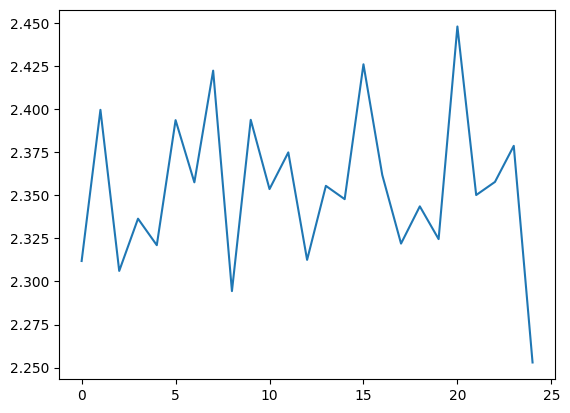

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(train_loss)

In [26]:
val_targets = []
val_preds = []

for i, batch in enumerate(val_dataloader):
    val_input, val_labels = batch
    # val_input = torch.swapaxes(val_input, 1, -2)

    grouped_inputs, grouped_labels = batch
    val_input = grouped_inputs.flatten(0, 1)[0].unsqueeze(0)
    val_labels = grouped_labels.flatten()[0].unsqueeze(0)


    val_input = val_input.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        outputs = model(val_input)

    val_targets.append(val_labels.detach().cpu().numpy()[0])
    val_preds.append(outputs.argmax(1).detach().cpu().numpy()[0])

print('F1:', f1_score(val_targets, val_preds, average='macro'))

Exception ignored in: <function tqdm.__del__ at 0x7f0fa4785120>
Exception ignored in: <function tqdm.__del__ at 0x7f0fa4785120>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/vdimitrov/project/venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
  File "/data/vdimitrov/project/venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/data/vdimitrov/project/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
    self.close()
  File "/data/vdimitrov/project/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f0fa4785120>Exception ignored in: 
Traceback (most recent call last):
<fu

F1: 0.031746031746031744


In [27]:
print('Accuracy:', accuracy_score(val_targets, val_preds))

Accuracy: 0.1111111111111111


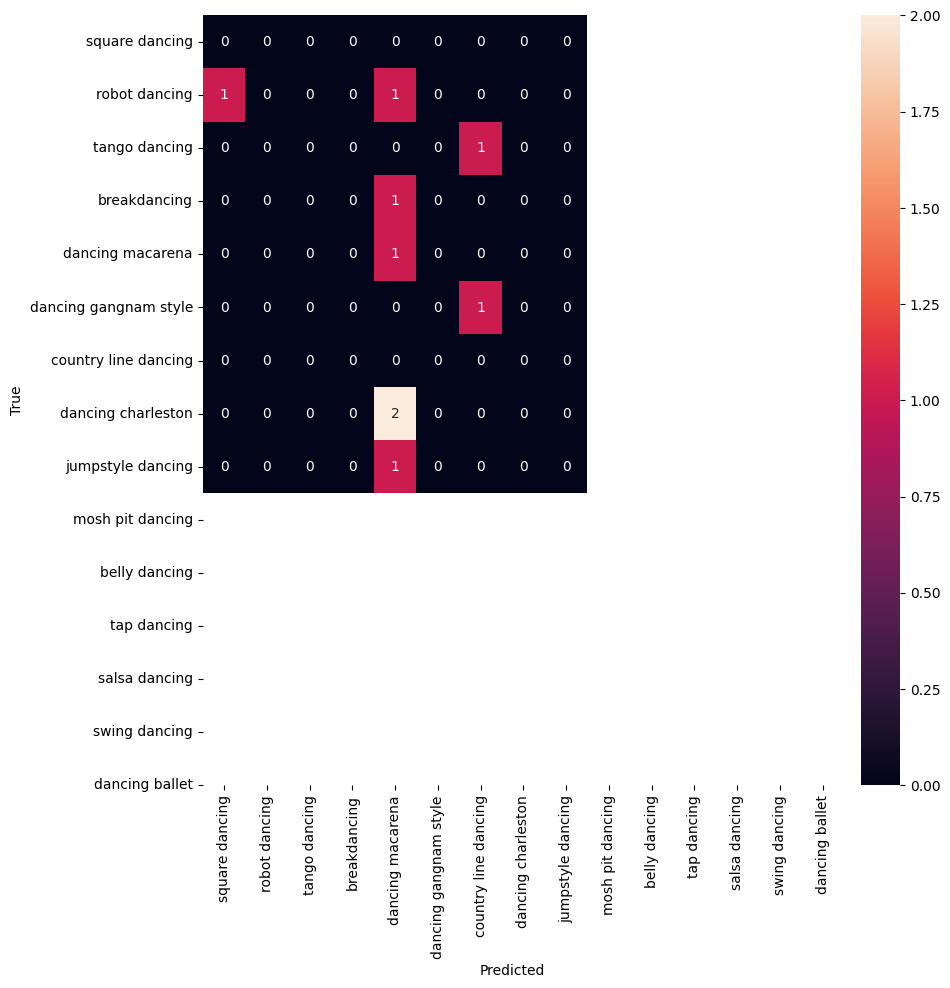

In [29]:
# make error matrix plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
torch.save(model.state_dict(), "resnet18.pkl")